actual training code


In [ ]:

!pip install mne wfdb tqdm scikit-learn torch torchvision torchaudio --quiet

In [ ]:
import os
import numpy as np
import mne
from scipy import signal
from scipy.signal.windows import gaussian
import wfdb
from glob import glob
from sklearn.model_selection import train_test_split
import gc

# ======================================
# CONFIGURATION
# ======================================
CHB_BASE_DIR = "/content/drive/MyDrive/chbmit"
PATIENT_ID = "chb15"
PATIENT_FOLDER = os.path.join(CHB_BASE_DIR, PATIENT_ID)
OUTDIR = "/content/chb_preprocessed"

os.makedirs(OUTDIR, exist_ok=True)

RESAMPLE_TO = 256  # CHB-MIT sampling rate
PREICTAL_SECONDS = 30 * 60  # 30 min preictal window
FREQ_MAX = 120

# 18 common channels across CHB-MIT (paper Section 2.1)
CHANNELS_KEEP = [
    "C3-P3","C4-P4","CZ-PZ","F3-C3","F4-C4","F7-T7","F8-T8","FP1-F3",
    "FP1-F7","FP2-F4","FP2-F8","FZ-CZ","P3-O1","P4-O2","P7-O1",
    "P8-O2","T7-P7"
]

# ======================================
# FUNCTIONS
# ======================================
def load_annotations_wfdb(edf_path):
    """Load seizure start/end times (seconds) from .seizures annotation file."""
    try:
        ann = wfdb.rdann(edf_path, extension="seizures")
        starts = [ann.sample[i] for i, sym in enumerate(ann.symbol) if sym == '[']
        ends = [ann.sample[i] for i, sym in enumerate(ann.symbol) if sym == ']']
        seizures = [(s / RESAMPLE_TO, e / RESAMPLE_TO - s / RESAMPLE_TO)
                    for s, e in zip(starts, ends)]
        return seizures
    except Exception:
        return []

def load_edf_with_annotations(edf_path, resample_to=None, picks=None):
    """Load EDF file, resample, and pick 18 common channels."""
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    if resample_to:
        raw.resample(resample_to, npad="auto")
    if picks:
        raw.pick_channels([ch for ch in picks if ch in raw.ch_names])
    seizures = load_annotations_wfdb(edf_path)
    return raw, seizures

def make_30sec_gaussian_spectrograms_with_overlap(raw, fs=RESAMPLE_TO,
                                                  freq_max=FREQ_MAX, stride_sec=10):
    """Compute 30-second STFT spectrograms with overlap, removing noise bands."""
    data = raw.get_data()
    channels, n_samples = data.shape
    samples_per_segment = int(fs * 30)
    stride_samples = int(fs * stride_sec)

    specs = []
    start_positions = range(0, n_samples - samples_per_segment + 1, stride_samples)

    for start in start_positions:
        segment = data[:, start:start + samples_per_segment]

        channel_specs = []
        for ch in range(channels):
            f, t, Zxx = signal.stft(segment[ch], fs=fs,
                                    window=gaussian(fs, std=fs / 6),
                                    nperseg=fs, noverlap=fs // 2,
                                    boundary=None, padded=False)
            # --- Remove power-line noise bands ---
            freq_mask = (f <= freq_max) & ~(((f >= 57) & (f <= 63)) | ((f >= 117) & (f <= 123)))
            Zxx = Zxx[freq_mask, :]

            # --- Magnitude and log scale ---
            zs = np.log1p(np.abs(Zxx))

            # --- Standardize each channel spectrogram ---
            zs = (zs - zs.mean()) / (zs.std() + 1e-8)

            channel_specs.append(zs.astype(np.float32))

        # Shape: (18, freq, time)
        specs.append(np.stack(channel_specs, axis=0))

    return specs, f[freq_mask], t, start_positions

def label_segments_with_overlap(start_positions, seizures,
                                segment_duration=30, preictal_seconds=PREICTAL_SECONDS,
                                sph_gap_sec=300):
    """
    Assign interictal=0, preictal=1, ictal=2 labels per 30-s window.
    Preictal labeling stops `sph_gap_sec` (default 300s = 5min) before seizure onset.
    """
    labels = np.zeros(len(start_positions), dtype=np.int8)

    for onset_sec, dur_sec in seizures:
        seizure_start = onset_sec
        seizure_end = onset_sec + dur_sec

        for i, segment_start_sample in enumerate(start_positions):
            segment_start_sec = segment_start_sample / RESAMPLE_TO
            segment_end_sec = segment_start_sec + segment_duration

            # Ictal
            if segment_start_sec < seizure_end and segment_end_sec > seizure_start:
                labels[i] = 2

            # Preictal (ends 5 min before seizure)
            elif (seizure_start - preictal_seconds) <= segment_start_sec < (seizure_start - sph_gap_sec):
                if labels[i] == 0:
                    labels[i] = 1
            # Else interictal (0)

    return labels

# ======================================
# MAIN PROCESSING
# ======================================
edf_files = sorted(glob(os.path.join(PATIENT_FOLDER, "*.edf")))
selected_files = []
interictal_only_count = 0

for f in edf_files:
    seizures_file = f + ".seizures"
    has_annotations = os.path.exists(seizures_file)
    if not has_annotations:
        if interictal_only_count < 10:
            selected_files.append(f)
            interictal_only_count += 1
            used = True
        else:
            used = False
    else:
        selected_files.append(f)
        used = True
    print(f"File: {os.path.basename(f)}, Annotations found: {has_annotations}, Used: {used}")

stride_sec = 10  # sliding window stride in seconds

# --- MEMORY-SAFE PROCESSING ---
temp_files = []

for i, edf in enumerate(selected_files):
    raw, seizures = load_edf_with_annotations(edf, resample_to=RESAMPLE_TO, picks=CHANNELS_KEEP)
    specs, freqs, times, start_positions = make_30sec_gaussian_spectrograms_with_overlap(raw, fs=RESAMPLE_TO, stride_sec=stride_sec)
    labels = label_segments_with_overlap(start_positions, seizures)

    print(f"{os.path.basename(edf)} -> Segments: {len(specs)}, "
          f"Ictal: {(labels == 2).sum()}, Preictal: {(labels == 1).sum()}, Interictal: {(labels == 0).sum()}")

    # save temp per-file to avoid RAM blow-up
    temp_path = os.path.join(OUTDIR, f"temp_{i}.npz")
    np.savez_compressed(temp_path, specs=np.array(specs, dtype=np.float32), labels=np.array(labels, dtype=np.int8))
    temp_files.append(temp_path)

    # free memory
    del specs, labels, raw
    gc.collect()

# --- LOAD TEMP FILES AND CONCATENATE ---
all_specs, all_labels = [], []
for temp_path in temp_files:
    data = np.load(temp_path)
    all_specs.append(data['specs'])
    all_labels.append(data['labels'])
    del data
    gc.collect()

all_specs = np.concatenate(all_specs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Train/test split (interictal + preictal only)
mask = (all_labels != 2)
X = all_specs[mask]
y = all_labels[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save final preprocessed data
np.savez_compressed(os.path.join(OUTDIR, f"{PATIENT_ID}_train.npz"),
                    specs=X_train, labels=y_train, fs=RESAMPLE_TO, freqs=freqs, times=times)
np.savez_compressed(os.path.join(OUTDIR, f"{PATIENT_ID}_test.npz"),
                    specs=X_test, labels=y_test, fs=RESAMPLE_TO, freqs=freqs, times=times)

print(f"✅ Done. Train shape: {X_train.shape}, Test shape: {X_test.shape}")


File: chb15_01.edf, Annotations found: False, Used: True
File: chb15_02.edf, Annotations found: False, Used: True
File: chb15_03.edf, Annotations found: False, Used: True
File: chb15_04.edf, Annotations found: False, Used: True
File: chb15_05.edf, Annotations found: False, Used: True
File: chb15_06.edf, Annotations found: True, Used: True
File: chb15_07.edf, Annotations found: False, Used: True
File: chb15_08.edf, Annotations found: False, Used: True
File: chb15_09.edf, Annotations found: False, Used: True
File: chb15_10.edf, Annotations found: True, Used: True
File: chb15_11.edf, Annotations found: False, Used: True
File: chb15_12.edf, Annotations found: False, Used: True
File: chb15_13.edf, Annotations found: False, Used: False
File: chb15_14.edf, Annotations found: False, Used: False
File: chb15_15.edf, Annotations found: True, Used: True
File: chb15_16.edf, Annotations found: False, Used: False
File: chb15_17.edf, Annotations found: True, Used: True
File: chb15_19.edf, Annotations 

/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_01.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_02.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_03.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_04.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_05.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_06.edf -> Segments: 358, Ictal: 15, Preictal: 0, Interictal: 343


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_07.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_08.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_09.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_10.edf -> Segments: 358, Ictal: 6, Preictal: 79, Interictal: 273


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_11.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_12.edf -> Segments: 358, Ictal: 0, Preictal: 0, Interictal: 358


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_15.edf -> Segments: 358, Ictal: 18, Preictal: 130, Interictal: 210


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_17.edf -> Segments: 358, Ictal: 6, Preictal: 150, Interictal: 202


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_20.edf -> Segments: 358, Ictal: 9, Preictal: 31, Interictal: 318


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_22.edf -> Segments: 358, Ictal: 23, Preictal: 46, Interictal: 289


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_28.edf -> Segments: 358, Ictal: 22, Preictal: 58, Interictal: 278


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_31.edf -> Segments: 358, Ictal: 15, Preictal: 146, Interictal: 197


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_40.edf -> Segments: 358, Ictal: 33, Preictal: 279, Interictal: 46


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_46.edf -> Segments: 358, Ictal: 13, Preictal: 150, Interictal: 195


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_49.edf -> Segments: 360, Ictal: 17, Preictal: 81, Interictal: 262


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_52.edf -> Segments: 358, Ictal: 10, Preictal: 48, Interictal: 300


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_54.edf -> Segments: 358, Ictal: 54, Preictal: 265, Interictal: 39


/tmp/ipython-input-546634874.py:49: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-546634874.py:49: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
chb15_62.edf -> Segments: 358, Ictal: 13, Preictal: 46, Interictal: 299
✅ Done. Train shape: (6672, 17, 110, 59), Test shape: (1668, 17, 110, 59)


In [ ]:


import os
import re
import math
import numpy as np
import mne
import wfdb
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_FCNN(nn.Module):
    def __init__(self, in_channels, freq_bins, time_bins, fc_out_dim=128):
        super(CNN_FCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 20, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 60, kernel_size=7, stride=2, padding=3)
        self.bn3 = nn.BatchNorm2d(60)
        self.relu = nn.ReLU()

        self.fc = None  # initialize later dynamically
        self.fc_out_dim = fc_out_dim

    def _forward_conv(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

    def forward(self, x):
        # Pass through conv stack
        x = self._forward_conv(x)

        # Rearrange to (B, Time, Features)
        x = x.permute(0, 3, 1, 2)  # (B, Time, Channels, Freq)
        B, T, C, F = x.shape
        x = x.reshape(B, T, C * F)

        # Initialize FC layer dynamically if not done
        if self.fc is None:
            self.flat_dim = C * F
            self.fc = nn.Linear(self.flat_dim, self.fc_out_dim).to(x.device)

        x = self.fc(x)
        return x
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=128, hidden_size=20, num_classes=2):
        super(BiLSTMClassifier, self).__init__()
        self.input_dropout = nn.Dropout(0.1)
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.output_dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.input_dropout(x)
        lstm_out, _ = self.bilstm(x)
        lstm_out = self.output_dropout(lstm_out)
        last_timestep = lstm_out[:, -1, :]
        logits = self.fc(last_timestep)
        return logits  # return raw logits

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix

# Load your preprocessed data
train_data = np.load("/content/chb_preprocessed/chb15_train.npz")
test_data = np.load("/content/chb_preprocessed/chb15_test.npz")

X_train = torch.tensor(train_data["specs"], dtype=torch.float32)
y_train = torch.tensor(train_data["labels"], dtype=torch.long)
X_test = torch.tensor(test_data["specs"], dtype=torch.float32)
y_test = torch.tensor(test_data["labels"], dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

# Instantiate models
num_channels = X_train.shape[1]
cnn = CNN_FCNN(in_channels=num_channels, freq_bins=59, time_bins=114, fc_out_dim=128)
bilstm = BiLSTMClassifier(input_size=128, hidden_size=20, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn, bilstm = cnn.to(device), bilstm.to(device)

# Combine into one optimizer
params = list(cnn.parameters()) + list(bilstm.parameters())
optimizer = torch.optim.RMSprop(params, lr=1e-4)
criterion = nn.CrossEntropyLoss()


train the model


In [ ]:
EPOCHS = 25
for epoch in range(EPOCHS):
    cnn.train(), bilstm.train()
    total_loss = 0
    preds, trues = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        features = cnn(xb)
        logits = bilstm(features)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(yb.cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f} | Train Acc: {acc:.3f}")

    # ----- Validation -----
    cnn.eval(), bilstm.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            feats = cnn(xb)
            logits = bilstm(feats)
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_trues.extend(yb.cpu().numpy())

    test_acc = accuracy_score(all_trues, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_trues, all_preds).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"   Test Acc: {test_acc:.3f} | Sensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}")


Epoch 1/25 | Loss: 0.4214 | Train Acc: 0.829
   Test Acc: 0.854 | Sensitivity: 0.351 | Specificity: 0.966
Epoch 2/25 | Loss: 0.3566 | Train Acc: 0.858
   Test Acc: 0.840 | Sensitivity: 0.142 | Specificity: 0.994
Epoch 3/25 | Loss: 0.3245 | Train Acc: 0.867
   Test Acc: 0.887 | Sensitivity: 0.623 | Specificity: 0.945
Epoch 4/25 | Loss: 0.2803 | Train Acc: 0.884
   Test Acc: 0.882 | Sensitivity: 0.738 | Specificity: 0.914
Epoch 5/25 | Loss: 0.2371 | Train Acc: 0.902
   Test Acc: 0.900 | Sensitivity: 0.586 | Specificity: 0.969
Epoch 6/25 | Loss: 0.1973 | Train Acc: 0.923
   Test Acc: 0.906 | Sensitivity: 0.765 | Specificity: 0.937
Epoch 7/25 | Loss: 0.1625 | Train Acc: 0.936
   Test Acc: 0.911 | Sensitivity: 0.570 | Specificity: 0.986
Epoch 8/25 | Loss: 0.1283 | Train Acc: 0.953
   Test Acc: 0.933 | Sensitivity: 0.815 | Specificity: 0.960
Epoch 9/25 | Loss: 0.1087 | Train Acc: 0.961
   Test Acc: 0.941 | Sensitivity: 0.755 | Specificity: 0.982
Epoch 10/25 | Loss: 0.0899 | Train Acc: 0.969


save current weights


In [ ]:
import torch

# Paths to save
cnn_path = "/content/drive/MyDrive/eegmodels/cnn_weights.pth"
bilstm_path = "/content/drive/MyDrive/eegmodels/bilstm_weights.pth"

# Save state_dict for each model
torch.save(cnn.state_dict(), cnn_path)
torch.save(bilstm.state_dict(), bilstm_path)

print("✅ CNN and BiLSTM weights saved separately!")


✅ CNN and BiLSTM weights saved separately!


load pretrained model

In [ ]:
import torch
import torch.nn as nn

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Combined model wrapper
class CombinedModel(nn.Module):
    def __init__(self, cnn_model, lstm_model):
        super(CombinedModel, self).__init__()
        self.cnn = cnn_model
        self.lstm = lstm_model

    def forward(self, x):
        features = self.cnn(x)  # fc layer exists and is trained
        logits = self.lstm(features)
        return logits

# --- Wrap trained submodules into the combined model ---
combined_model = CombinedModel(cnn, bilstm).to(device)




xplainable ai


In [ ]:
!pip install shap
!pip install lime
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7f8bd131f3c5b677d4fe8c47b53d22ed681efacc1ca975006a520caf8084db28
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# Force both modules into training mode
cnn.train()
bilstm.train()
combined_model.train()

print("After fix:")
print("combined_model.training:", combined_model.training)
print("cnn.training:", cnn.training, "bilstm.training:", bilstm.training)


After fix:
combined_model.training: True
cnn.training: True bilstm.training: True


⚙️ cuDNN disabled temporarily for SHAP backward pass.
Using 16 background samples, 16 test samples.
🧠 Computing SHAP values on GPU with cuDNN disabled... this may take a few minutes.
⚠️ SHAP returned single output, wrapped in list.
Class 0: SHAP shape = (16, 17, 110, 59, 2)


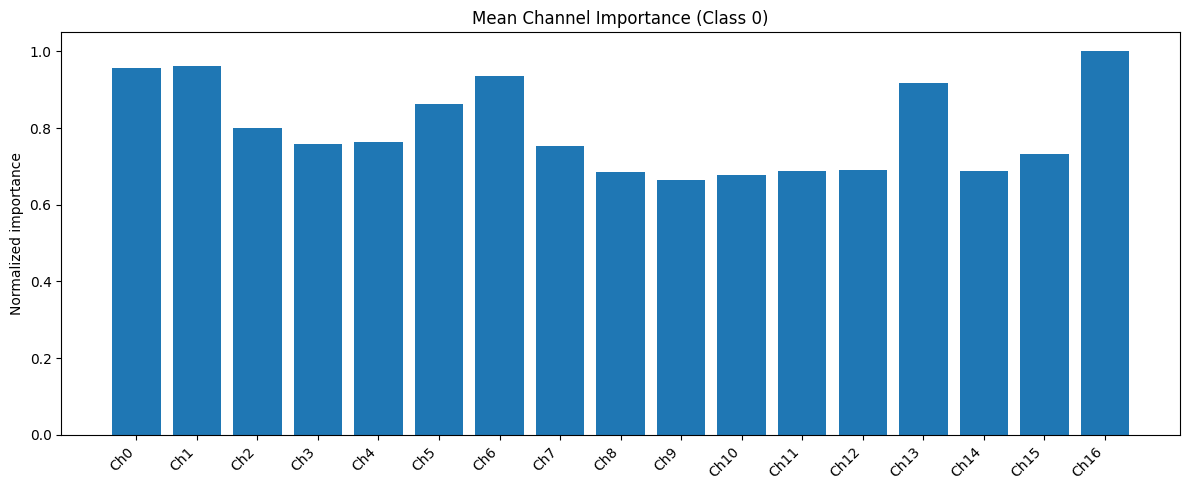

🔁 cuDNN re-enabled. Safe to resume normal training/evaluation.


In [ ]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. Disable cuDNN globally for SHAP
# --------------------------------------------
orig_cudnn_state = torch.backends.cudnn.enabled
torch.backends.cudnn.enabled = False
print("⚙️ cuDNN disabled temporarily for SHAP backward pass.")

# --------------------------------------------
# 2. Prepare data
# --------------------------------------------
patient_npz = "/content/chb_preprocessed/chb15_test.npz"
data = np.load(patient_npz, allow_pickle=True)

X = data["specs"]
y = data["labels"]
ch_names = data.get("ch_names", [f"Ch{i}" for i in range(X.shape[1])])

# pick preictal windows for analysis
preictal_mask = (y == 1)
X_preictal_np = X[preictal_mask]

# convert to torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_preictal = torch.tensor(X_preictal_np, dtype=torch.float32, device=device)

# smaller background/test sets for faster SHAP
background = X_preictal[:16]
test_batch = X_preictal[16:32]

# --------------------------------------------
# 3. Prepare model for SHAP
# --------------------------------------------
combined_model.to(device)
combined_model.eval()

print(f"Using {background.shape[0]} background samples, {test_batch.shape[0]} test samples.")
print("🧠 Computing SHAP values on GPU with cuDNN disabled... this may take a few minutes.")

# --------------------------------------------
# 4. Compute SHAP values
# --------------------------------------------
explainer = shap.GradientExplainer(model=combined_model, data=background)
shap_values = explainer.shap_values(test_batch)

# shap_values is a list (one array per class)
if isinstance(shap_values, list):
    print(f"✅ Got SHAP values for {len(shap_values)} classes.")
else:
    shap_values = [shap_values]
    print("⚠️ SHAP returned single output, wrapped in list.")

for i, sv in enumerate(shap_values):
    print(f"Class {i}: SHAP shape = {np.shape(sv)}")

# --------------------------------------------
# 5. Visualization — handle variable shapes
# --------------------------------------------
for cls_idx, sv in enumerate(shap_values):
    sv = np.abs(sv)  # importance magnitude
    sv = np.nan_to_num(sv)

    # Detect channel dimension automatically (assume second axis)
    if sv.ndim == 3:
        # (samples, channels, time)
        mean_importance = np.mean(sv, axis=(0, 2))
    elif sv.ndim == 4:
        # (samples, channels, freq, time) or similar
        mean_importance = np.mean(sv, axis=(0, 2, 3))
    elif sv.ndim == 5:
        # (samples, channels, freq, time, extra)
        mean_importance = np.mean(sv, axis=(0, 2, 3, 4))
    else:
        # fallback — average over everything except channels
        reduce_axes = tuple(ax for ax in range(sv.ndim) if ax != 1)
        mean_importance = np.mean(sv, axis=reduce_axes)

    # normalize
    mean_importance /= np.max(mean_importance) + 1e-8

    # plot
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(ch_names)), mean_importance)
    plt.xticks(range(len(ch_names)), ch_names, rotation=45, ha='right')
    plt.title(f"Mean Channel Importance (Class {cls_idx})")
    plt.ylabel("Normalized importance")
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# 6. Restore cuDNN state
# --------------------------------------------
torch.backends.cudnn.enabled = orig_cudnn_state
print("🔁 cuDNN re-enabled. Safe to resume normal training/evaluation.")


In [ ]:
# Assuming X_preictal is your input tensor
print("X_preictal shape:", X_preictal.shape)

# Or if you're using a DataLoader:
xb, yb = next(iter(test_loader))
print("Batch shape:", xb.shape)


X_preictal shape: torch.Size([302, 17, 110, 59])
Batch shape: torch.Size([16, 17, 110, 59])


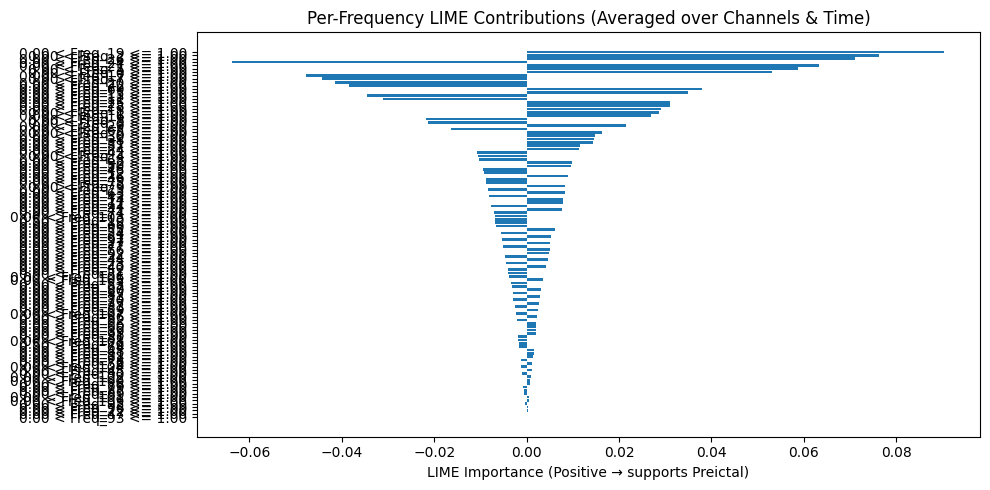

In [ ]:
import numpy as np
import torch
from lime import lime_tabular
import matplotlib.pyplot as plt

device = next(combined_model.parameters()).device

# ------------------------------------
# Choose one EEG window to explain
# ------------------------------------
x = X_preictal[0].clone()  # shape: (channels, freqs, times)
num_channels, num_freqs, num_times = x.shape

# ------------------------------------
# Define predict_fn that LIME will call
# ------------------------------------
def predict_fn(freq_masks):
    preds = []
    for mask in freq_masks:
        x_pert = x.clone()
        for f_idx, active in enumerate(mask):
            if not active:
                # Mask this frequency across all channels and time
                mean_val = x[:, f_idx, :].mean()
                x_pert[:, f_idx, :] = mean_val

        with torch.no_grad():
            logits = combined_model(x_pert.unsqueeze(0).to(device))
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds.append(probs[0])
    return np.array(preds)

# ------------------------------------
# Generate random frequency masks as "training data"
# ------------------------------------
n_samples = 200
training_masks = np.random.randint(0, 2, size=(n_samples, num_freqs))

# ------------------------------------
# Create LIME explainer
# ------------------------------------
freq_names = [f"Freq_{i}" for i in range(num_freqs)]

explainer = lime_tabular.LimeTabularExplainer(
    training_data=training_masks,
    feature_names=freq_names,
    mode='classification'
)

# ------------------------------------
# Explain this EEG window
# ------------------------------------
exp = explainer.explain_instance(
    data_row=np.ones(num_freqs),
    predict_fn=predict_fn,
    num_features=num_freqs
)

# ------------------------------------
# Plot frequency importance
# ------------------------------------
freq_labels, contributions = zip(*exp.as_list())

plt.figure(figsize=(10, 5))
plt.barh(freq_labels, contributions)
plt.xlabel("LIME Importance (Positive → supports Preictal)")
plt.title("Per-Frequency LIME Contributions (Averaged over Channels & Time)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Debug: check if model predictions change when we mask channels
for mask_fraction in [0.0, 0.25, 0.5, 0.75, 1.0]:
    mask = np.ones(17)
    num_to_mask = int(17 * mask_fraction)
    mask[:num_to_mask] = 0
    np.random.shuffle(mask)

    prob = predict_fn(mask.reshape(1, -1))
    print(f"Masked {mask_fraction*100:.0f}% channels → Pred prob: {prob[0][0]:.4f}")


Masked 0% channels → Pred prob: 0.9910
Masked 25% channels → Pred prob: 0.7158
Masked 50% channels → Pred prob: 0.0043
Masked 75% channels → Pred prob: 0.9031
Masked 100% channels → Pred prob: 0.4749


⚙️ cuDNN disabled temporarily for SHAP backward pass.
Loaded: Preictal 302 windows, Interictal 1366 windows

🧠 Explaining Preictal vs Interictal (contrast): background=64, test=128
  -> SHAP shape: (128, 17, 110, 59, 2)

🧠 Explaining Interictal vs Preictal (contrast): background=64, test=128
  -> SHAP shape: (128, 17, 110, 59, 2)
Saved /content/shap_outputs/preictal_channel_prop.png


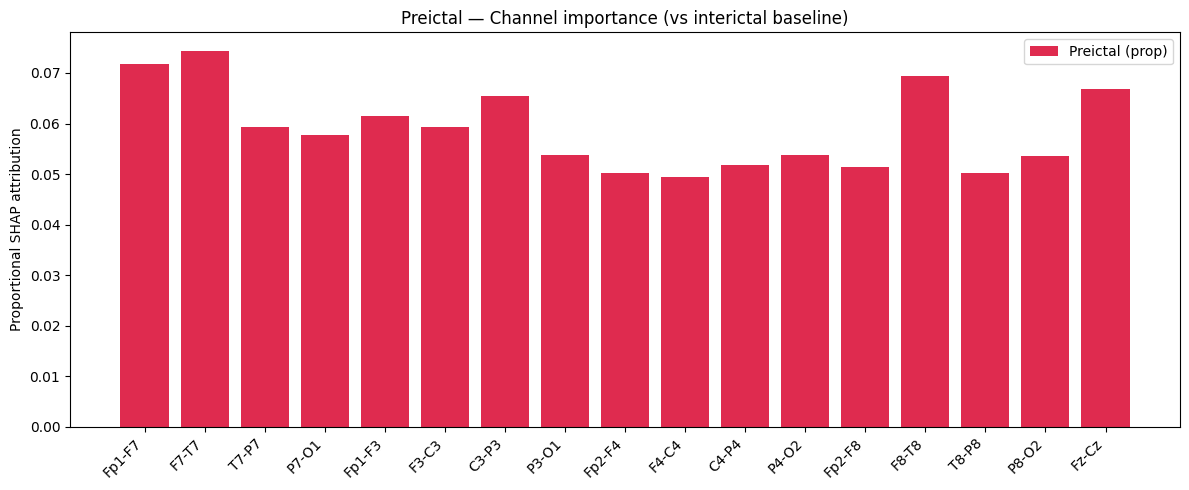

Saved /content/shap_outputs/interictal_channel_prop.png


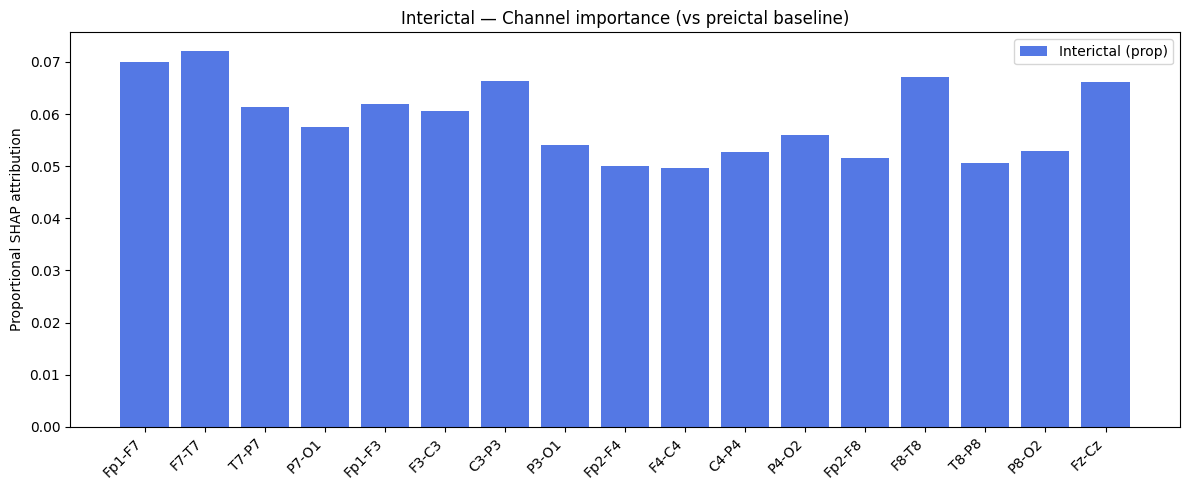

Saved /content/shap_outputs/channel_delta_shap.png


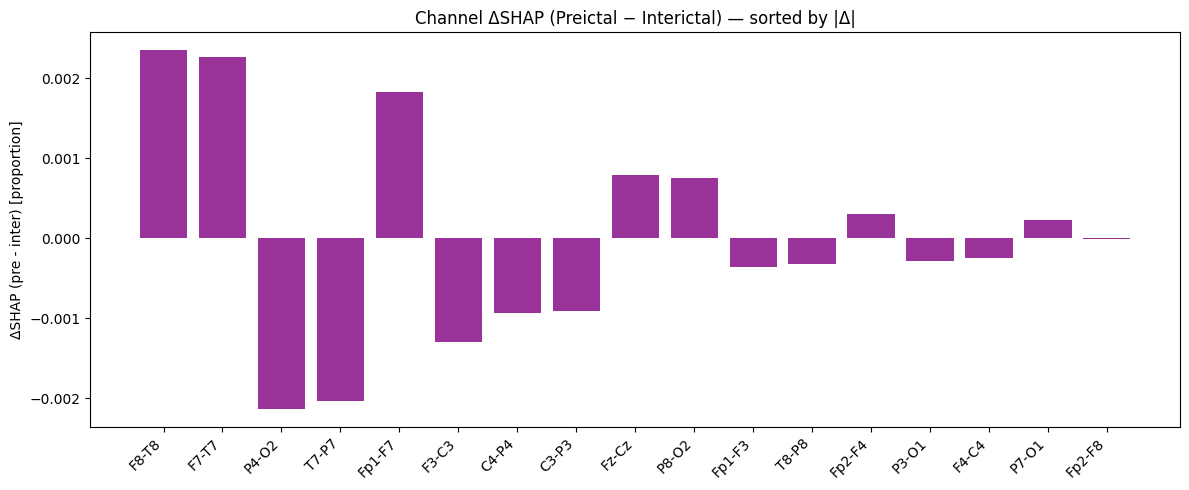

Saved /content/shap_outputs/preictal_band_prop.png


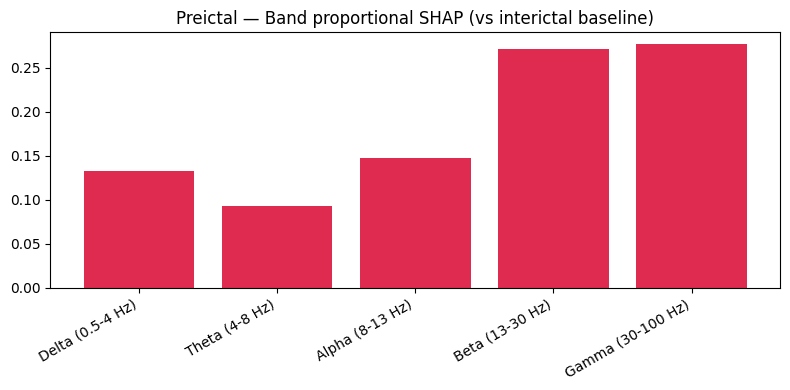

Saved /content/shap_outputs/interictal_band_prop.png


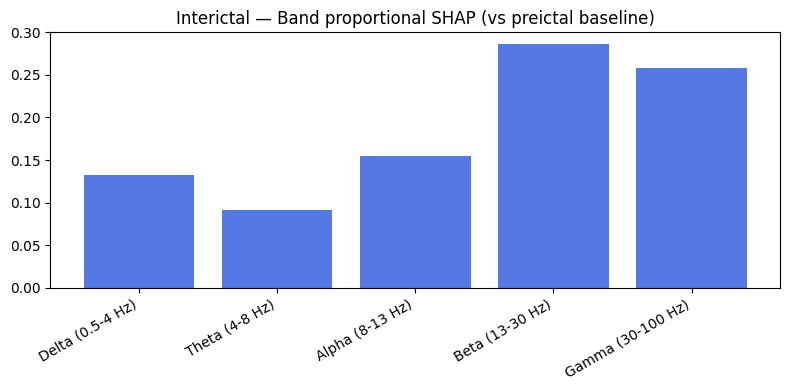

Saved /content/shap_outputs/band_delta_shap.png


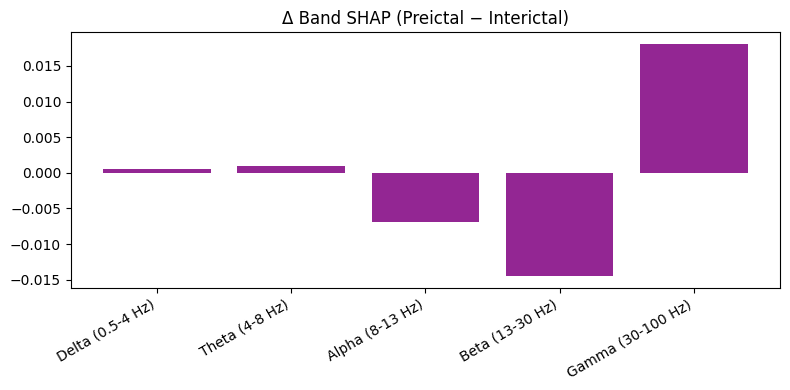

Saved /content/shap_outputs/ch_freq_pre_heatmap.png


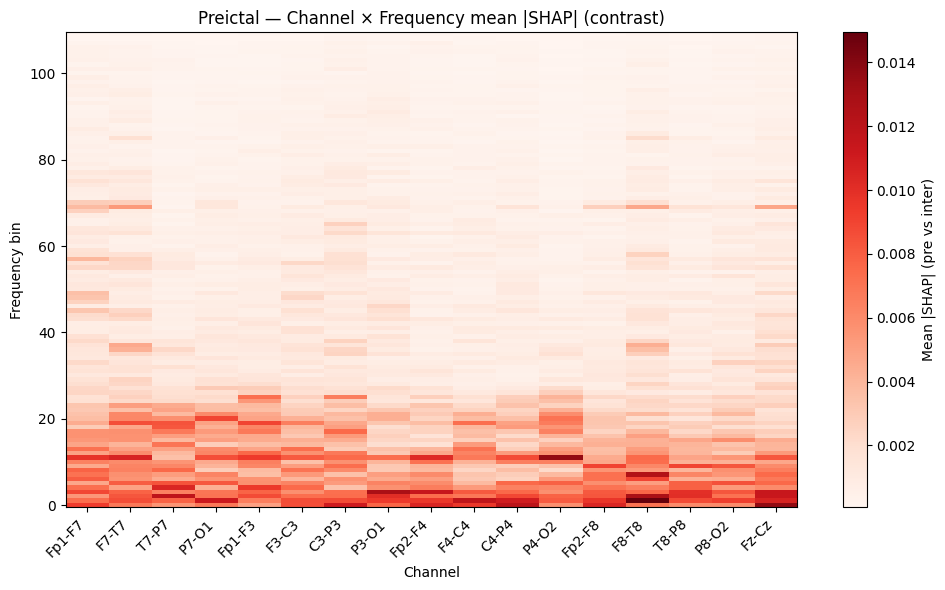

Saved /content/shap_outputs/ch_freq_inter_heatmap.png


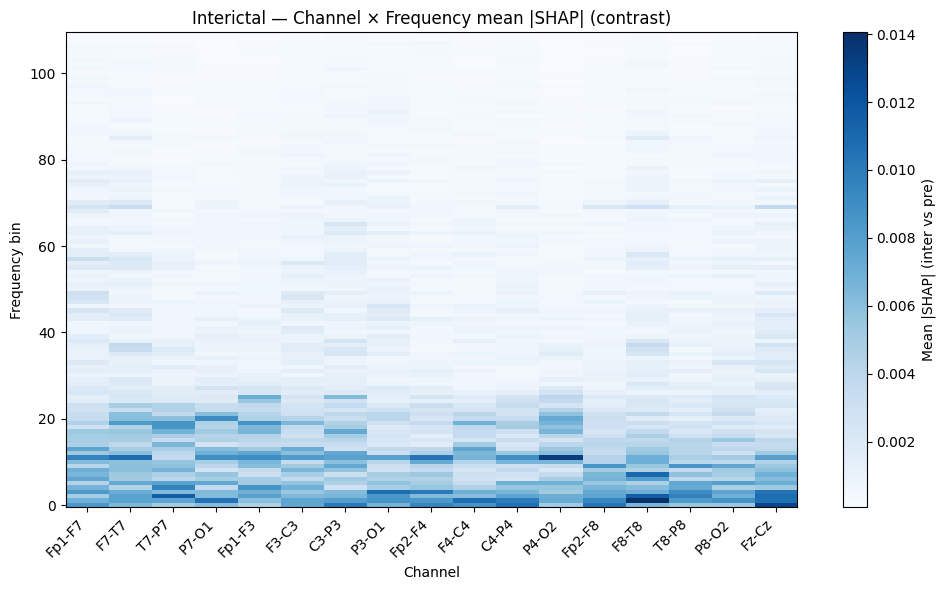


Diagnostics:
Pre vs Inter SHAP: samples=128, channels=17, freqs=110, times=59
  mean |SHAP| per-channel (first 8): [[0.0023 0.0022]
 [0.0023 0.0022]
 [0.0019 0.0018]
 [0.0018 0.0017]
 [0.0019 0.0019]
 [0.0019 0.0018]
 [0.0021 0.002 ]
 [0.0017 0.0016]]
  std |SHAP| per-channel (first 8): [[0.0053 0.0051]
 [0.0056 0.0054]
 [0.0052 0.005 ]
 [0.0051 0.0049]
 [0.0054 0.0052]
 [0.0048 0.0047]
 [0.0051 0.005 ]
 [0.0048 0.0047]]
Inter vs Pre SHAP: samples=128, channels=17, freqs=110, times=59
  mean |SHAP| per-channel (first 8): [[0.002  0.0019]
 [0.0021 0.002 ]
 [0.0018 0.0017]
 [0.0017 0.0016]
 [0.0018 0.0017]
 [0.0018 0.0017]
 [0.0019 0.0018]
 [0.0016 0.0015]]
  std |SHAP| per-channel (first 8): [[0.005  0.0048]
 [0.0053 0.0051]
 [0.005  0.0049]
 [0.0051 0.0049]
 [0.0054 0.0052]
 [0.0048 0.0046]
 [0.0053 0.0051]
 [0.0046 0.0045]]
🔁 cuDNN re-enabled. Done.


In [ ]:
import os
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
patient_npz = "/content/chb_preprocessed/chb15_test.npz"
OUT_DIR = "/content/shap_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 1. Disable cuDNN globally (temporary)
# -----------------------------
orig_cudnn_state = torch.backends.cudnn.enabled
torch.backends.cudnn.enabled = False
print("⚙️ cuDNN disabled temporarily for SHAP backward pass.")

# -----------------------------
# 2. Load data
# -----------------------------
data = np.load(patient_npz, allow_pickle=True)
X = data["specs"]  # (samples, channels, freqs, times)
y = data["labels"]
ch_names = data.get("ch_names", [f"Ch{i}" for i in range(X.shape[1])])
n_freq_bins = X.shape[2]

# Frequency axis: adjust if your spectrogram uses a different max freq
freqs = np.linspace(0, 128, n_freq_bins)  # example: 0..128 Hz

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 3. Split per-class and convert to torch
# -----------------------------
X_preictal_np = X[y == 1]
X_interictal_np = X[y == 0]

def to_torch(x_np):
    return torch.tensor(x_np, dtype=torch.float32, device=device)

X_preictal = to_torch(X_preictal_np)
X_interictal = to_torch(X_interictal_np)

print(f"Loaded: Preictal {len(X_preictal_np)} windows, Interictal {len(X_interictal_np)} windows")

# -----------------------------
# 4. Prepare model (must exist in scope)
# -----------------------------
combined_model.to(device)
combined_model.eval()

# -----------------------------
# 5. SHAP computation strategy (contrastive)
# -----------------------------
def compute_shap(background_tensor, test_tensor, desc, max_bg=64, max_test=128):
    """Compute SHAP values using GradientExplainer."""
    bg = background_tensor[:max_bg]
    test = test_tensor[:max_test]

    print(f"\n🧠 Explaining {desc}: background={len(bg)}, test={len(test)}")
    explainer = shap.GradientExplainer(model=combined_model, data=bg)
    shap_values = explainer.shap_values(test)
    if not isinstance(shap_values, list):
        shap_values = [shap_values]
    sv = shap_values[0]
    sv = np.nan_to_num(sv)
    print(f"  -> SHAP shape: {sv.shape}")
    return sv, bg, test

# Explain preictal using interictal as background
sv_pre_vs_inter, bg_inter, test_pre = compute_shap(X_interictal, X_preictal, "Preictal vs Interictal (contrast)")

# Explain interictal using preictal as background
sv_inter_vs_pre, bg_pre, test_inter = compute_shap(X_preictal, X_interictal, "Interictal vs Preictal (contrast)")

# -----------------------------
# 6. Importance aggregation helpers
# -----------------------------
def agg_channel_freq(sv):
    """Aggregate absolute SHAP values into per-channel and per-frequency summaries."""
    a = np.abs(sv)
    if a.ndim == 5:
        a = a.mean(axis=-1)
    ch_imp = a.mean(axis=(0, 2, 3))        # (channels,)
    freq_imp = a.mean(axis=(0, 1, 3))      # (freqs,)
    ch_freq = a.mean(axis=(0, 3))          # (channels, freqs)
    return ch_imp, freq_imp, ch_freq

ch_pre, freq_pre, chfreq_pre = agg_channel_freq(sv_pre_vs_inter)
ch_inter, freq_inter, chfreq_inter = agg_channel_freq(sv_inter_vs_pre)

# -----------------------------
# 7. Normalize (proportional normalization)
# -----------------------------
def prop_normalize(vec):
    s = vec.sum()
    return vec / (s + 1e-12)

ch_pre_prop = prop_normalize(ch_pre)
ch_inter_prop = prop_normalize(ch_inter)

freq_pre_prop = prop_normalize(freq_pre)
freq_inter_prop = prop_normalize(freq_inter)

chfreq_pre_prop = chfreq_pre
chfreq_inter_prop = chfreq_inter

# -----------------------------
# 8. EEG band aggregation
# -----------------------------
bands = {
    "Delta (0.5-4 Hz)": (0.5, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-13 Hz)": (8, 13),
    "Beta (13-30 Hz)": (13, 30),
    "Gamma (30-100 Hz)": (30, 100)
}

def band_aggregation(freqs, freq_prop):
    band_imp = {}
    for bname, (fmin, fmax) in bands.items():
        mask = (freqs >= fmin) & (freqs < fmax)
        if mask.sum() > 0:
            band_imp[bname] = freq_prop[mask].sum()
        else:
            band_imp[bname] = 0.0
    return band_imp

band_pre = band_aggregation(freqs, freq_pre_prop)
band_inter = band_aggregation(freqs, freq_inter_prop)

# -----------------------------
# 9. ΔSHAP (preictal - interictal)
# -----------------------------
ch_delta = ch_pre_prop - ch_inter_prop
band_delta = {k: band_pre[k] - band_inter[k] for k in band_pre.keys()}

# -----------------------------
# 10. Replace numeric labels with real EEG channel names
# -----------------------------
channel_map = {
    0: "Fp1-F7", 1: "F7-T7", 2: "T7-P7", 3: "P7-O1",
    4: "Fp1-F3", 5: "F3-C3", 6: "C3-P3", 7: "P3-O1",
    8: "Fp2-F4", 9: "F4-C4", 10: "C4-P4", 11: "P4-O2",
    12: "Fp2-F8", 13: "F8-T8", 14: "T8-P8", 15: "P8-O2",
    16: "Fz-Cz", 17: "Cz-Pz", 18: "P7-T7", 19: "O1-O2",
    20: "T8-P8", 21: "Fpz-Cz"
}

if all(name.startswith("Ch") for name in ch_names):
    ch_names = [channel_map.get(i, f"Ch{i}") for i in range(len(ch_names))]

# -----------------------------
# 11. Plotting + save outputs
# -----------------------------
def save_fig(fig, name):
    path = os.path.join(OUT_DIR, name)
    fig.savefig(path, bbox_inches="tight")
    print(f"Saved {path}")

# Channel bar plots
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(ch_names)), ch_pre_prop, color='crimson', alpha=0.9, label='Preictal (prop)')
plt.xticks(np.arange(len(ch_names)), ch_names, rotation=45, ha='right')
plt.ylabel("Proportional SHAP attribution")
plt.title("Preictal — Channel importance (vs interictal baseline)")
plt.legend()
plt.tight_layout()
save_fig(plt.gcf(), "preictal_channel_prop.png")
plt.show()

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(ch_names)), ch_inter_prop, color='royalblue', alpha=0.9, label='Interictal (prop)')
plt.xticks(np.arange(len(ch_names)), ch_names, rotation=45, ha='right')
plt.ylabel("Proportional SHAP attribution")
plt.title("Interictal — Channel importance (vs preictal baseline)")
plt.legend()
plt.tight_layout()
save_fig(plt.gcf(), "interictal_channel_prop.png")
plt.show()

# ΔSHAP per-channel (sorted)
order = np.argsort(-np.abs(ch_delta))
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(ch_names)), ch_delta[order], color='purple', alpha=0.8)
plt.xticks(np.arange(len(ch_names)), np.array(ch_names)[order], rotation=45, ha='right')
plt.ylabel("ΔSHAP (pre - inter) [proportion]")
plt.title("Channel ΔSHAP (Preictal − Interictal) — sorted by |Δ|")
plt.tight_layout()
save_fig(plt.gcf(), "channel_delta_shap.png")
plt.show()

# Band-level plots
plt.figure(figsize=(8,4))
plt.bar(list(band_pre.keys()), list(band_pre.values()), color='crimson', alpha=0.9)
plt.title("Preictal — Band proportional SHAP (vs interictal baseline)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
save_fig(plt.gcf(), "preictal_band_prop.png")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(list(band_inter.keys()), list(band_inter.values()), color='royalblue', alpha=0.9)
plt.title("Interictal — Band proportional SHAP (vs preictal baseline)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
save_fig(plt.gcf(), "interictal_band_prop.png")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(list(band_delta.keys()), list(band_delta.values()), color='purple', alpha=0.85)
plt.title("Δ Band SHAP (Preictal − Interictal)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
save_fig(plt.gcf(), "band_delta_shap.png")
plt.show()

# Channel-frequency heatmaps
plt.figure(figsize=(10,6))
plt.imshow(chfreq_pre_prop.T, aspect='auto', origin='lower', cmap='Reds')
plt.colorbar(label="Mean |SHAP| (pre vs inter)")
plt.xlabel("Channel")
plt.ylabel("Frequency bin")
plt.title("Preictal — Channel × Frequency mean |SHAP| (contrast)")
plt.xticks(np.arange(len(ch_names)), ch_names, rotation=45, ha='right')
plt.tight_layout()
save_fig(plt.gcf(), "ch_freq_pre_heatmap.png")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(chfreq_inter_prop.T, aspect='auto', origin='lower', cmap='Blues')
plt.colorbar(label="Mean |SHAP| (inter vs pre)")
plt.xlabel("Channel")
plt.ylabel("Frequency bin")
plt.title("Interictal — Channel × Frequency mean |SHAP| (contrast)")
plt.xticks(np.arange(len(ch_names)), ch_names, rotation=45, ha='right')
plt.tight_layout()
save_fig(plt.gcf(), "ch_freq_inter_heatmap.png")
plt.show()

# -----------------------------
# 12. Diagnostics
# -----------------------------
def print_diag(sv, label):
    print(f"{label} SHAP: samples={sv.shape[0]}, channels={sv.shape[1]}, freqs={sv.shape[2]}, times={sv.shape[3]}")
    print(f"  mean |SHAP| per-channel (first 8): {np.round(np.abs(sv).mean(axis=(0,2,3))[:8],4)}")
    print(f"  std |SHAP| per-channel (first 8): {np.round(np.abs(sv).std(axis=(0,2,3))[:8],4)}")

print("\nDiagnostics:")
print_diag(sv_pre_vs_inter, "Pre vs Inter")
print_diag(sv_inter_vs_pre, "Inter vs Pre")

# -----------------------------
# 13. Restore cuDNN
# -----------------------------
torch.backends.cudnn.enabled = orig_cudnn_state
print("🔁 cuDNN re-enabled. Done.")


⚙️ cuDNN disabled temporarily for SHAP backward pass.
Loaded: Preictal 302 windows, Interictal 1366 windows

🧠 Explaining Preictal vs Interictal: background=64, test=128
  -> SHAP shape: (128, 17, 110, 59, 2)

🧠 Explaining Interictal vs Preictal: background=64, test=128
  -> SHAP shape: (128, 17, 110, 59, 2)


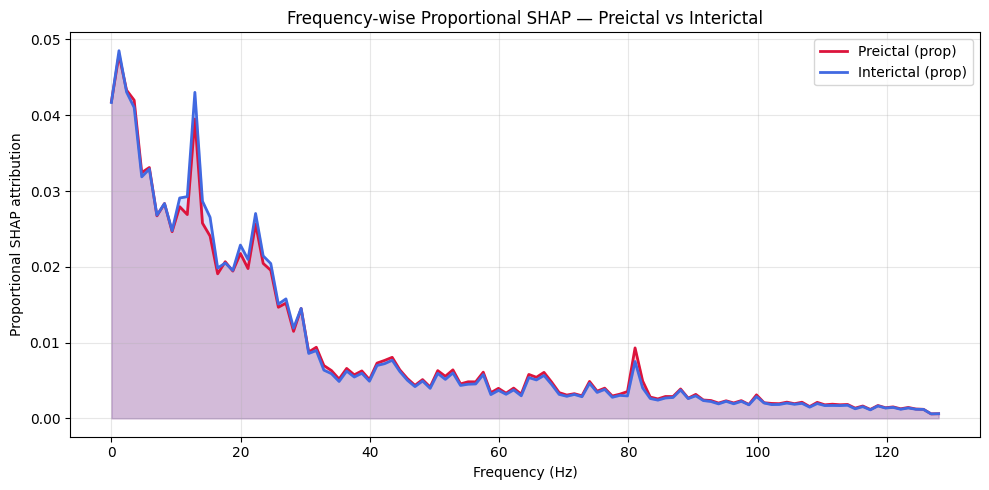

✅ Saved frequency SHAP plot at: /content/shap_outputs/freq_shap_prop.png
🔁 cuDNN re-enabled. Done.


In [ ]:
import os
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
patient_npz = "/content/chb_preprocessed/chb15_test.npz"
OUT_DIR = "/content/shap_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 1. Disable cuDNN globally (temporary)
# -----------------------------
orig_cudnn_state = torch.backends.cudnn.enabled
torch.backends.cudnn.enabled = False
print("⚙️ cuDNN disabled temporarily for SHAP backward pass.")

# -----------------------------
# 2. Load data
# -----------------------------
data = np.load(patient_npz, allow_pickle=True)
X = data["specs"]  # (samples, channels, freqs, times)
y = data["labels"]
n_freq_bins = X.shape[2]

# Build frequency axis (0–128 Hz)
freqs = np.linspace(0, 128, n_freq_bins)

# Detect if frequency axis is inverted
mean_power_per_freq = X.mean(axis=(0, 1, 3))
if mean_power_per_freq[0] < mean_power_per_freq[-1]:
    print("⚠️ Detected inverted frequency axis — flipping it!")
    X = np.flip(X, axis=2)
    mean_power_per_freq = mean_power_per_freq[::-1]

# -----------------------------
# 3. Split per-class and convert to torch
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_preictal_np = X[y == 1]
X_interictal_np = X[y == 0]

def to_torch(x_np):
    return torch.tensor(x_np, dtype=torch.float32, device=device)

X_preictal = to_torch(X_preictal_np)
X_interictal = to_torch(X_interictal_np)

print(f"Loaded: Preictal {len(X_preictal_np)} windows, Interictal {len(X_interictal_np)} windows")

# -----------------------------
# 4. Prepare model
# -----------------------------
combined_model.to(device)
combined_model.eval()

# -----------------------------
# 5. SHAP computation
# -----------------------------
def compute_shap(background_tensor, test_tensor, desc, max_bg=64, max_test=128):
    bg = background_tensor[:max_bg]
    test = test_tensor[:max_test]

    print(f"\n🧠 Explaining {desc}: background={len(bg)}, test={len(test)}")
    explainer = shap.GradientExplainer(model=combined_model, data=bg)
    shap_values = explainer.shap_values(test)
    if not isinstance(shap_values, list):
        shap_values = [shap_values]
    sv = shap_values[0]
    sv = np.nan_to_num(sv)
    print(f"  -> SHAP shape: {sv.shape}")
    return sv

sv_pre_vs_inter = compute_shap(X_interictal, X_preictal, "Preictal vs Interictal")
sv_inter_vs_pre = compute_shap(X_preictal, X_interictal, "Interictal vs Preictal")

# -----------------------------
# 6. Frequency-level aggregation
# -----------------------------
def agg_freq(sv):
    a = np.abs(sv)
    if a.ndim == 5:
        a = a.mean(axis=-1)
    freq_imp = a.mean(axis=(0, 1, 3))  # (freqs,)
    return freq_imp

freq_pre = agg_freq(sv_pre_vs_inter)
freq_inter = agg_freq(sv_inter_vs_pre)

# -----------------------------
# 7. Normalize to proportional scale
# -----------------------------
def prop_normalize(vec):
    s = vec.sum()
    return vec / (s + 1e-12)

freq_pre_prop = prop_normalize(freq_pre)
freq_inter_prop = prop_normalize(freq_inter)

# -----------------------------
# 8. Plot proportional frequency SHAP
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(freqs, freq_pre_prop, color='crimson', lw=2, label='Preictal (prop)')
plt.plot(freqs, freq_inter_prop, color='royalblue', lw=2, label='Interictal (prop)')
plt.fill_between(freqs, freq_pre_prop, alpha=0.2, color='crimson')
plt.fill_between(freqs, freq_inter_prop, alpha=0.2, color='royalblue')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Proportional SHAP attribution")
plt.title("Frequency-wise Proportional SHAP — Preictal vs Interictal")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "freq_shap_prop.png")
plt.savefig(out_path, bbox_inches="tight")
plt.show()

print(f"✅ Saved frequency SHAP plot at: {out_path}")

# -----------------------------
# 9. Restore cuDNN
# -----------------------------
torch.backends.cudnn.enabled = orig_cudnn_state
print("🔁 cuDNN re-enabled. Done.")
